In [1]:
# Import the libraries that we will use for our analysis
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from scipy.stats import chi2_contingency

In [2]:
# Read the csv files we will use in our analysis
observations = pd.read_csv("observations.csv")
species = pd.read_csv("species_info.csv")

In [3]:
# Let's get a picture of how our data is structured with a sample of the datasets
display(observations.sample(10))
display(species.sample(10))

,scientific_name,park_name,observations
20232,Baptisia tinctoria,Bryce National Park,97
19308,Bromus anomalus,Yosemite National Park,159
2510,Hemizonia kelloggii,Yellowstone National Park,255
12586,Osmorhiza claytonii,Bryce National Park,67
1285,Sphagnum pylaesii,Bryce National Park,95
13850,Scutellaria integrifolia,Yellowstone National Park,216
18249,Lotus wrangelianus,Great Smoky Mountains National Park,100
21681,Verbena urticifolia,Great Smoky Mountains National Park,55
21276,Zonotrichia atricapilla,Great Smoky Mountains National Park,36
4512,Orthilia secunda,Yosemite National Park,133


,category,scientific_name,common_names,conservation_status
1995,Vascular Plant,Carex frankii,"Frank Sedge, Frank's Sedge",NaN
9,Mammal,Canis rufus,Red Wolf,Endangered
775,Vascular Plant,Cirsium vulgare,Bull Thistle,NaN
153,Bird,Tringa flavipes,Lesser Yellowlegs,NaN
3899,Vascular Plant,Isoetes occidentalis,Western Quillwort,NaN
2163,Vascular Plant,Bromus latiglumis,Earlyleaf Brome,NaN
1047,Vascular Plant,Draba verna,Whitlow Grass,NaN
4934,Vascular Plant,Descurainia californica,"Sierra Tansymustard, Sierran Tansy Mustard, Si...",NaN
3802,Vascular Plant,Ledum glandulosum,"Glandular Labrador Tea, Western Labrador Tea",NaN
4255,Vascular Plant,Panicum capillare,"Annual Witchgrass, Common Panic Grass, Common ...",NaN


Looking at both of our dataframes, we can say:
* The dataframe of observations holds information of the scientific name, park name and the number of observations of that species
* The dataframe of species hold information about that species as the category, the common name and the conservation status.

As how the data is structure, the data types of our dataframes should be mostly strings/objects, but our column observations that must be an integer. In the case of conservation status, even though is a string, for better purposes in the analysis we can make it as a categorical variable.

In [4]:
# Visualization of the data types in our dataframes

print("Let's visualize the observation dataframe data types: ")
display(observations.dtypes)

print("--------------------------------------------------------")

print("Let's visualize the species dataframe data types: ")
display(species.dtypes)

Let's visualize the observation dataframe data types: 


scientific_name    object
park_name          object
observations        int64
dtype: object

--------------------------------------------------------
Let's visualize the species dataframe data types: 


category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

In [5]:
# Before any kind of analysis let's check if our dataset has duplicated information
print(f"The observations dataframe has a total of {observations.duplicated().sum()} duplicated rows")
print(f"The species dataframe has a total of {species.duplicated().sum()} duplicated rows")

observations.drop_duplicates(inplace = True)
print(f"The observations dataframe has a total of {observations.duplicated().sum()} duplicated rows after dropping duplicates")


The observations dataframe has a total of 15 duplicated rows
The species dataframe has a total of 0 duplicated rows
The observations dataframe has a total of 0 duplicated rows after dropping duplicates


In [6]:
# Because our categorical data can't have null values, let's evaluate first what kind of missingness we have in that values
print("The total number of values for each specific value is:")
display(species.conservation_status.value_counts())
print(f"The total number of observations is {species.conservation_status.shape[0]}")
print(f"The total number of null values in conservation_status is {species.conservation_status.isnull().sum()}")
print(f"Therefore, the percentage of missing data is: {round(species.conservation_status.isnull().sum()/species.conservation_status.shape[0]*100, 2)}%")

The total number of values for each specific value is:


Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64

The total number of observations is 5824
The total number of null values in conservation_status is 5633
Therefore, the percentage of missing data is: 96.72%


In [7]:
# 96.72 percent of the data is missing, we could probably guess that's because they're species that as a normal status and wasn't recorded, but let's dive in a bit more
missing_data = species[species.conservation_status.isnull()]
# Now that we have the missing data, we will check that amout of missing data by other columns to check for patterns
print("Missing data for Category")
print(missing_data.category.value_counts())
print("--------------------------------------------")

print("Missing data for Scientific Name")
print(missing_data.scientific_name.value_counts())
print("--------------------------------------------")

print("Missing data for Common Names")
print(missing_data.common_names.value_counts())

Missing data for Category
Vascular Plant       4424
Bird                  442
Nonvascular Plant     328
Mammal                176
Fish                  116
Reptile                74
Amphibian              73
Name: category, dtype: int64
--------------------------------------------
Missing data for Scientific Name
Streptopelia decaocto    3
Hypochaeris radicata     3
Castor canadensis        3
Columba livia            3
Holcus lanatus           3
                        ..
Carex brevior            1
Carex blanda             1
Carex biltmoreana        1
Carex barrattii          1
Tribulus terrestris      1
Name: scientific_name, Length: 5363, dtype: int64
--------------------------------------------
Missing data for Common Names
Brachythecium Moss                                                            7
Dicranum Moss                                                                 7
Bryum Moss                                                                    6
Panic Grass            

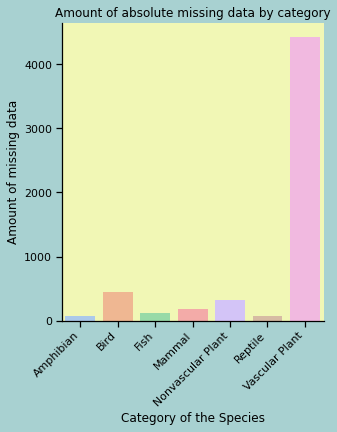

<Figure size 432x288 with 0 Axes>

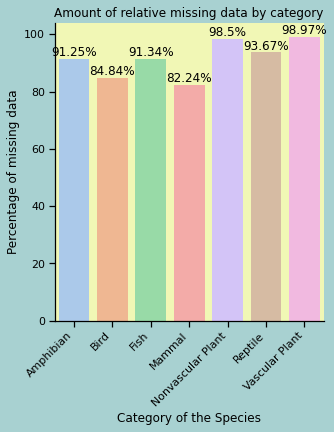

<Figure size 432x288 with 0 Axes>

In [8]:
# We can check for patterns in category columns
# Let's evaluate the absolute and relative amount od missing data
missingdata_bycategory = species["conservation_status"].isnull().groupby(species["category"]).sum().reset_index() # We calculate the missing data we have by category
notmissingdata_bycategory = species["conservation_status"].notnull().groupby(species["category"]).sum().reset_index() # We calculate the total amount of data that's not missed by category
missingvsnomissing = missingdata_bycategory.merge(notmissingdata_bycategory, how = "inner", on = "category", suffixes = ["_miss","_notmiss"]) # We merge both dataframes
missingvsnomissing["Percentage"] = np.round(missingvsnomissing.conservation_status_miss/(missingvsnomissing.conservation_status_miss+missingvsnomissing.conservation_status_notmiss)*100, 2) # we calculate the percentage of missing data across categories
missingvsnomissing

# Set the theme we will use in our analysis
sns.set_theme(palette = "pastel", style = {"axes.facecolor": "#F1F7B5", "figure.facecolor": "#A8D1D1"})

# Create a barplot for visualizing the missing data
sns.catplot(data = missingvsnomissing, x = "category", y = "conservation_status_miss", kind = "bar")
plt.title("Amount of absolute missing data by category")
plt.xlabel("Category of the Species")
plt.ylabel("Amount of missing data")
plt.xticks(rotation = 45, ha = "right")
plt.savefig("charts/Amount of absolute missing data by category.jpg", bbox_inches='tight')
plt.show()
plt.clf()

# Create a barplot for visualizing the relative missing data across categories
g = sns.catplot(data = missingvsnomissing, x = "category", y = "Percentage", kind = "bar")
ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(v.get_height()):}%' for v in c]
    ax.bar_label(c, labels = labels, label_type = "edge")
plt.title("Amount of relative missing data by category")
plt.xlabel("Category of the Species")
plt.ylabel("Percentage of missing data")
plt.xticks(rotation = 45, ha = "right")
plt.savefig("charts/Amount of relative missing data by category.jpg", bbox_inches='tight')
plt.show()
plt.clf()

After analysing better our null values we can see that most of the missed values correspond to Vascular Plants, however when we make an analysis of the percentage of missing data by categories we can see that actual difference is not much. If we compare separate between plants, vascular and non vascular has a similar amount of missing data. In the animals case, amphibian, fish and reptiles they have a little more missing percentage than birds and mammals.
After this analysis, we are going to conclude that this missing data is a structurally missing data, because that species that doesn't have value is because they are not consider within the categories measured.

In [9]:
# Our observations column is an integer data type, therefore we won't need to change that data type, although we need to change our conservation_status column which is an object, but we want to create a categorical variable
print(species.conservation_status.unique())

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


We will take the next table as a reference for ordering the conservation_status:

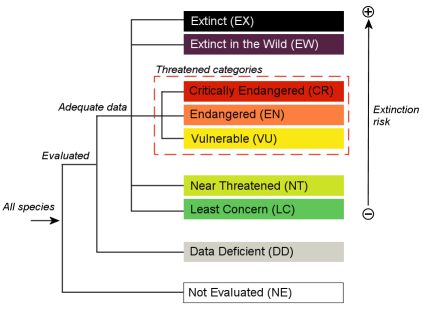

In [10]:
# First, we fill our null values with not endangered
species.conservation_status.fillna("Not Endangered", inplace = True)

# We modify our column conservation status
categories_order = ["Not Endangered", "Species of Concern", "Threatened", "Endangered",  "In Recovery"]
species.conservation_status = pd.Categorical(species.conservation_status,
                                             categories = categories_order,
                                             ordered = True)


In [11]:
# Check that our column is succesfully modified
display(species.conservation_status.sample(5))
print(species.dtypes)

1345    Not Endangered
3178    Not Endangered
5500    Not Endangered
4251    Not Endangered
3899    Not Endangered
Name: conservation_status, dtype: category
Categories (5, object): ['Not Endangered' < 'Species of Concern' < 'Threatened' < 'Endangered' < 'In Recovery']

category                 object
scientific_name          object
common_names             object
conservation_status    category
dtype: object


In [12]:
# Let's check for missing data in the observations dataframe
observations.info()
# Seems there are no missing values, let's check for possible abnormalities with a summarie of statistics
observations.describe(include = "all")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23281 non-null  object
 1   park_name        23281 non-null  object
 2   observations     23281 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 545.6+ KB


,scientific_name,park_name,observations
count,23281,23281,23281.000000
unique,5541,4,NaN
top,Castor canadensis,Bryce National Park,NaN
freq,12,5823,NaN
mean,NaN,NaN,142.280357
std,NaN,NaN,69.885439
min,NaN,NaN,9.000000
25%,NaN,NaN,86.000000
50%,NaN,NaN,124.000000
75%,NaN,NaN,195.000000


For our columns scientific name and park name, we can see our mode value and the frequencies of that value. There's a total of 4 different parks in our dataframe. The number of observations seems alright, without any kind abnormality. It's curious how the mean is almost 20 observations different from the mean, we can plot a violinplot in order to know more about the distribution of the data

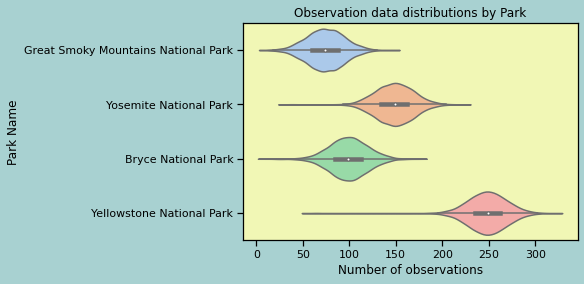

<Figure size 432x288 with 0 Axes>

In [13]:
sns.violinplot(x = observations["observations"],
               y = observations.park_name,
               inner = "box", orient = "h",
              scale = "area")
plt.title("Observation data distributions by Park")
plt.xlabel("Number of observations")
plt.ylabel("Park Name")
plt.savefig("charts/Observation data distributions by park.jpg", bbox_inches='tight')
plt.show()
plt.clf()

In [14]:
# Observe the specific values of the descriptive analysis for each park
observations.groupby("park_name").observations.describe().reset_index()

,park_name,count,mean,std,min,25%,50%,75%,max
0,Bryce National Park,5823.0,98.901082,20.761239,9.0,85.0,99.0,113.0,176.0
1,Great Smoky Mountains National Park,5818.0,74.145411,20.323467,10.0,60.0,74.0,88.0,147.0
2,Yellowstone National Park,5819.0,247.862863,23.175947,57.0,235.0,249.0,262.0,321.0
3,Yosemite National Park,5821.0,148.228139,21.220545,31.0,134.0,149.0,162.0,223.0


During the analysis of our observations dataframe, we were concerned that possibly the number of observations had outliers that could be troublesome for our analysis, after checking the distribution of data for each park we could assume that our data doesn't have irregularities

Now that our data has been analysed from missing and outlier/abnormalities in data we can continue with out exploratory analysis.

# Objectives of the project

We want to analyse the biodiversity of species at 4 different parks:

* Bruce National Park
* Great Smoky Mountains National Park
* Yellowstone National Park
* Yosemite National Park

We know we have 7 different categories of species:
* Mammal
* Bird
* Reptile
* Amphibian
* Fish
* Vascular Plant
* Non Vascular Plant

The questions that first arise are:
* Has any park specialized in any specific category of these species?
* Is there any correlation between vascular and non vascular plants with the conservation status?
* Is it more likely that one of the species has worse conservation status than others?


In [15]:
# For all our questions we want to answer we need to combine both dataframes
df = observations.merge(species, on = "scientific_name", how = "inner")
# Let's check for possible duplicated values
print("The final dataframe for analysis has a total of {} duplicated rows".format(df.duplicated().sum()))

The final dataframe for analysis has a total of 0 duplicated rows


In [16]:
df.sample(10)

,scientific_name,park_name,observations,category,common_names,conservation_status
21857,Wilsonia citrina,Great Smoky Mountains National Park,91,Bird,Hooded Warbler,Not Endangered
24217,Avena barbata,Yosemite National Park,118,Vascular Plant,"Slender Oat, Slender Oats, Slender Wildoat",Not Endangered
25388,Salix barclayi,Great Smoky Mountains National Park,60,Vascular Plant,Barclay's Willow,Not Endangered
2838,Isothecium myosuroides,Yellowstone National Park,273,Nonvascular Plant,Isothecium Moss,Not Endangered
7441,Rubus laciniatus,Yosemite National Park,156,Vascular Plant,"Cutleaf Blackberry, Cut-Leaved Blackberry",Not Endangered
13825,Festuca rubra,Bryce National Park,91,Vascular Plant,Red Fescue,Not Endangered
19860,Aralia racemosa,Bryce National Park,120,Vascular Plant,"American Spikenard, Wild Spikenard",Not Endangered
22209,Cardamine hirsuta,Bryce National Park,107,Vascular Plant,"Hairy Bittercress, Hairy Bitter-Cress",Not Endangered
515,Accipiter cooperii,Great Smoky Mountains National Park,65,Bird,Cooper's Hawk,Species of Concern
5925,Arabis inyoensis,Yellowstone National Park,236,Vascular Plant,Inyo Rockcress,Not Endangered


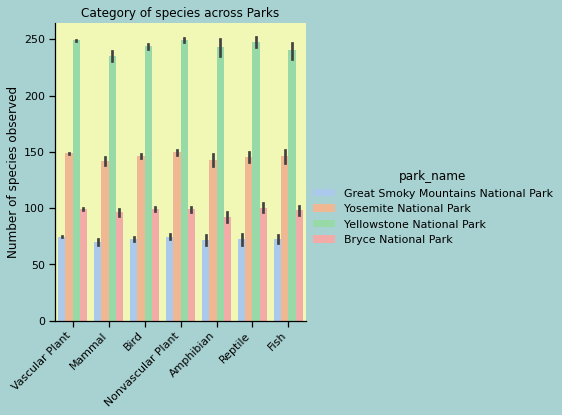

<Figure size 432x288 with 0 Axes>

In [17]:
# Let's start answering our first question:
# Is there any park specialized in any specific category of the species we have in our data
sns.catplot(data = df, x = "category", y = "observations",
            kind = "bar", hue = "park_name")
plt.title("Category of species across Parks")
plt.xlabel("")
plt.ylabel("Number of species observed")
plt.xticks(rotation = 45, ha = "right")
plt.savefig("charts/Category of species across parks.jpg", bbox_inches='tight')
plt.show()
plt.clf()

In [18]:
# Even though we don't see that there's a difference between parks and their category in species, let's analyze it with numbers
# We create a frequency table of parks and categories
park_category_table = pd.crosstab(df.park_name, df.category)

# We analyse the data with a chi squared test
chi2, pval, dof, expected = chi2_contingency(park_category_table)

In [19]:
# We get a expected table of the values in each park and category
expected = pd.DataFrame(np.round(expected, 2), columns = park_category_table.columns).set_index(park_category_table.index)


In [20]:
# Now we print the frequency table we had
park_category_table

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
park_name,,,,,,,
Bryce National Park,82,591,131,300,333,81,4888
Great Smoky Mountains National Park,82,591,131,300,333,81,4878
Yellowstone National Park,82,588,131,298,333,81,4884
Yosemite National Park,82,591,131,300,333,81,4884


In [21]:
# We print the expected frequency table we should have had
expected

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
park_name,,,,,,,
Bryce National Park,82.07,590.78,131.12,299.77,333.30,81.07,4887.89
Great Smoky Mountains National Park,81.95,589.86,130.91,299.30,332.78,80.95,4880.26
Yellowstone National Park,81.96,589.95,130.93,299.35,332.83,80.96,4881.02
Yosemite National Park,82.02,590.41,131.04,299.58,333.09,81.02,4884.84


In [22]:
# Comparing both tables there's no difference between them
print(f"The result of our chi squared test is {chi2} with a p-value of {pval}")
# Plus the results of our chi squared tell us that there's no association between these variables

The result of our chi squared test is 0.02178879276222688 with a p-value of 1.0


We are visualising the park Bryce National Park


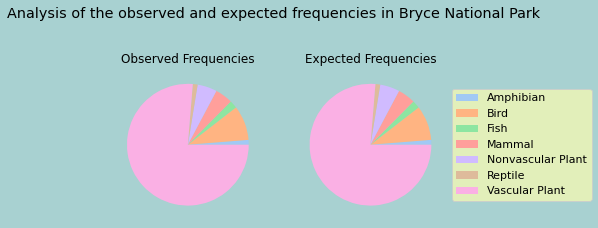

We are visualising the park Great Smoky Mountains National Park


<Figure size 432x288 with 0 Axes>

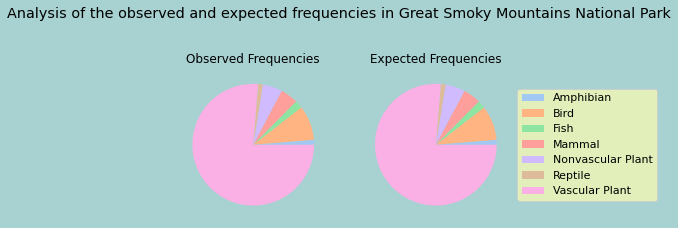

We are visualising the park Yellowstone National Park


<Figure size 432x288 with 0 Axes>

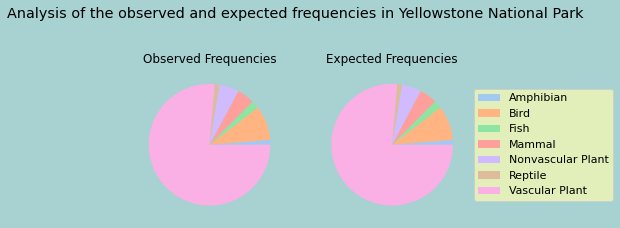

We are visualising the park Yosemite National Park


<Figure size 432x288 with 0 Axes>

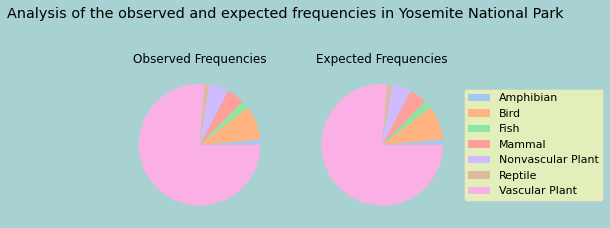

<Figure size 432x288 with 0 Axes>

In [23]:
park_category_chart = park_category_table.reset_index().melt(id_vars = "park_name",
                                       value_vars = ["Amphibian", "Bird", "Fish", "Mammal", "Nonvascular Plant", "Reptile", "Vascular Plant"],
                                      var_name = "Category",
                                       value_name = "Count"
                                      )
park_category_expected_chart = expected.reset_index().melt(id_vars = "park_name",
                                       value_vars = ["Amphibian", "Bird", "Fish", "Mammal", "Nonvascular Plant", "Reptile", "Vascular Plant"],
                                      var_name = "Category",
                                       value_name = "Expected_count"
                                      )
for park in park_category_chart.park_name.unique():
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    filtered = park_category_chart[park_category_chart.park_name == park]
    expected_filtered = park_category_expected_chart[park_category_expected_chart.park_name == park]
    print("We are visualising the park {}".format(park))
    plt.title("Observed Frequencies")
    plt.pie(filtered.Count)
    plt.subplot(1, 2, 2)
    plt.title("Expected Frequencies")
    plt.pie(expected_filtered.Expected_count)
    plt.legend(filtered.Category.unique(),
              loc = "center left", bbox_to_anchor = (1, 0.5))
    fig.suptitle(f"Analysis of the observed and expected frequencies in {park}")
    plt.savefig(f"charts/Analysis of the observed and expected frequencies in {park}.jpg", bbox_inches='tight')
    plt.show()
    plt.clf()

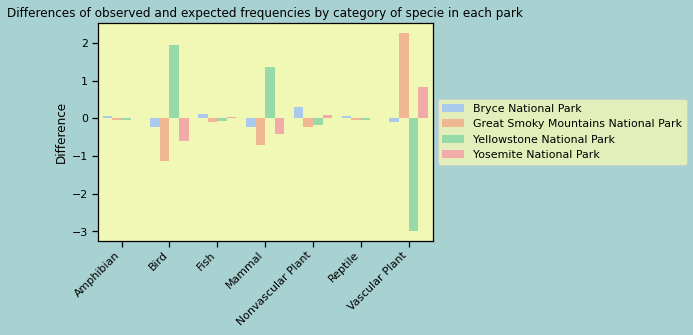

<Figure size 432x288 with 0 Axes>

In [24]:
dif = park_category_expected_chart.Expected_count - park_category_chart.Count
dif = pd.DataFrame(dif, columns = ["Dif"])
dif["park_name"] = park_category_chart.park_name
dif["category"] = park_category_chart.Category
sns.barplot(data = dif, x = "category", y = "Dif", hue = "park_name")
plt.title("Differences of observed and expected frequencies by category of specie in each park")
plt.xlabel("")
plt.ylabel("Difference")
plt.xticks(rotation = 45, ha = "right")
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.savefig("charts/Differences of observed and expected frequencies by category of species in each park.jpg", bbox_inches='tight')
plt.show()
plt.clf()

After our analysis in the relation between park and category of species, we can conclude that there's no correlation between both variables. There's no probabilities of observing a specific category of specie if you go to one of the parks.

Our next question is related to the plants that we have observed in our parks. And what we want to know is if there's any relation between Vascular and Nonvascular plants and their status of conservation

In [25]:
# We create a specific dataframe of only plants, so we can focus on only that information
plants = df[df.category.str.contains("Plant")]
# We will make a tabular table with both variables
plants_freq = pd.crosstab(plants.category, plants.conservation_status)
chi2, pval, dof, expected = chi2_contingency(plants_freq)
print(f"The test of chi squared as a value of {chi2} with a p-value of {pval}")
expected = pd.DataFrame(np.round(expected, 2), columns = plants.conservation_status.unique()).set_index(plants_freq.index)
display(plants_freq)
display(expected)

The test of chi squared as a value of 6.083545358785323 with a p-value of 0.10761555815783161


conservation_status,Not Endangered,Species of Concern,Threatened,Endangered
category,,,,
Nonvascular Plant,1312,20,0,0
Vascular Plant,19350,172,8,4


,Not Endangered,Species of Concern,Endangered,Threatened
category,,,,
Nonvascular Plant,1318.98,12.26,0.51,0.26
Vascular Plant,19343.02,179.74,7.49,3.74


In this case there's a small difference between categorical variables between their conservation status and the type of plant we would be talking about, our statistical analysis says that there's a 10.76% that our results are explained by randomness, but it's not enough to tell a significant result, we would need more sample in order to confirm if both variables has a relationship.

For our last question, we would like to know if there's any relationship between the category of the species and the conservation status.

In [26]:
category_conservation_freq = pd.crosstab(df.category, df.conservation_status)
chi2, pval, dof, expected = chi2_contingency(category_conservation_freq)
print(f"The test of chi squared as a value of {chi2} with a p-value of {pval}")
expected = pd.DataFrame(np.round(expected, 2), columns = df.conservation_status.unique()).set_index(category_conservation_freq.index)
display(category_conservation_freq)
display(expected)

The test of chi squared as a value of 3130.2175493161594 with a p-value of 0.0


conservation_status,Not Endangered,Species of Concern,Threatened,Endangered,In Recovery
category,,,,,
Amphibian,300,16,8,4,0
Bird,2013,320,0,16,12
Fish,476,16,20,12,0
Mammal,966,168,8,44,12
Nonvascular Plant,1312,20,0,0,0
Reptile,304,20,0,0,0
Vascular Plant,19350,172,8,4,0


,Not Endangered,Species of Concern,Threatened,Endangered,In Recovery
category,,,,,
Amphibian,316.73,9.38,0.56,1.02,0.31
Bird,2279.84,67.51,4.06,7.38,2.21
Fish,505.99,14.98,0.90,1.64,0.49
Mammal,1156.82,34.25,2.06,3.74,1.12
Nonvascular Plant,1286.21,38.09,2.29,4.16,1.25
Reptile,312.86,9.26,0.56,1.01,0.30
Vascular Plant,18862.54,558.53,33.57,61.04,18.31


In [27]:
dif = category_conservation_freq - expected

In [28]:
dif

conservation_status,Not Endangered,Species of Concern,Threatened,Endangered,In Recovery
category,,,,,
Amphibian,-16.73,6.62,7.44,2.98,-0.31
Bird,-266.84,252.49,-4.06,8.62,9.79
Fish,-29.99,1.02,19.10,10.36,-0.49
Mammal,-190.82,133.75,5.94,40.26,10.88
Nonvascular Plant,25.79,-18.09,-2.29,-4.16,-1.25
Reptile,-8.86,10.74,-0.56,-1.01,-0.30
Vascular Plant,487.46,-386.53,-25.57,-57.04,-18.31


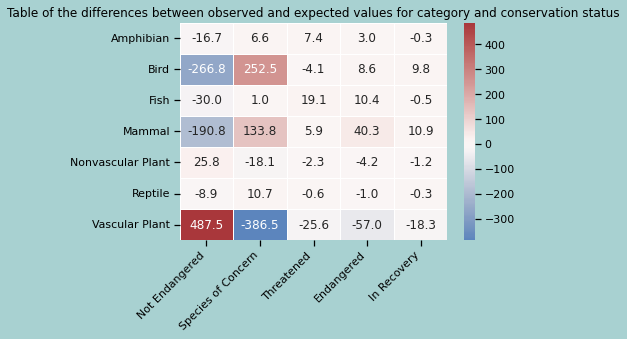

In [29]:
sns.heatmap(dif, center = 0, annot = True, fmt = ".1f", linewidth = 0.5, cmap = "vlag")
plt.title("Table of the differences between observed and expected values for category and conservation status")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation = 45, ha = "right")
plt.savefig("charts/Table of differences between observed and expected values for category and conservation status.jpg", bbox_inches='tight')

After our analysis, we can conclude that not only there's a relation between the category and the conservation status of the species, in addition, we can relate that for vascular plants we've observed less species of concern than expected; the opposite we would expect for mammals and birds that we observed more species in concern that what we could expect.